# Triangle Centrality

From the paper by Paul Burkhardt:

[https://arxiv.org/pdf/2105.00110.pdf](https://arxiv.org/pdf/2105.00110.pdf)

"Triangle centrality is introduced for finding important vertices in a graph based on the concentration of triangles surrounding each vertex.  An important vertex in triangle centrality is at the center of many triangles, and therefore it may be in many triangles or none at all."

First construct a symmetric test graph, this is the same graph as Figure 2 in the paper:

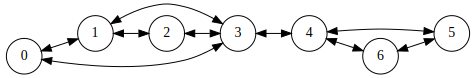

In [1]:
from pygraphblas import  *
from pygraphblas.gviz import *

a = 0
b = 1
c = 2
V = 3
d = 4
e = 5
f = 6

A = Matrix.from_lists(
    [a, a, b, b, c, d, d, d, e],
    [b, V, c, V, V, V, e, f, f],
    [1.0] * 9, 8, 8)

A = A + A.T # make it symmetric

draw(A, show_weight=False)

# Version 1

This first version is a straightforward translation of the original algorithm from the paper:

[https://arxiv.org/pdf/2105.00110.pdf#subsection.8.2](https://arxiv.org/pdf/2105.00110.pdf#subsection.8.2)

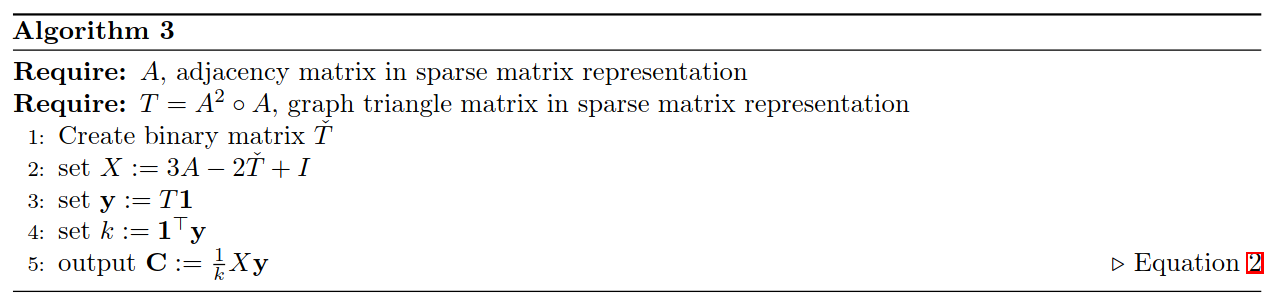

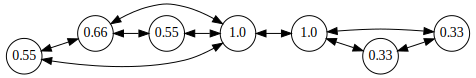

In [2]:

def triangle_centrality(A):
    I = Matrix.identity(A.type, A.nrows)
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    T_hat = T.pattern(A.type)
    X = (3 * A) - (2 * T_hat) + I
    return (1/k) * (X @ y)

draw(A, label_vector=triangle_centrality(A), label_width=4, show_weight=False)  

# Version 2 (faster)

[SuiteSparse:GraphBLAS](https://github.com/DrTimothyAldenDavis/GraphBLAS) author Tim Davis suggested the following improvements:

 - Distribute mxv with y on both sides of the subtraction
 - Compute T_hat implicitly with PLUS_SECOND

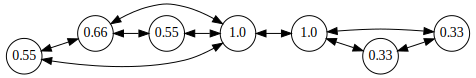

In [3]:

def triangle_centrality2(A):
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    z = 3 * (A @ y) - 2 * (T.mxv(y, semiring=FP64.PLUS_SECOND)) + y
    return (1/k) * z

draw(A, label_vector=triangle_centrality2(A), label_width=4, show_weight=False)  

# Karate Graph

One of the examples used in the paper is the Zachary Karate Graph.  This is available in the matrix market as 'Newman/karate'

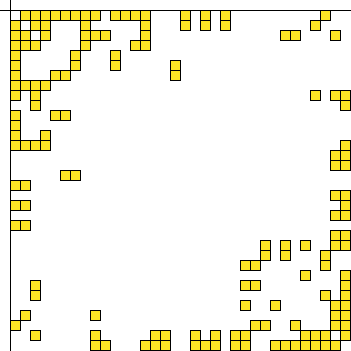

In [4]:
k = list(Matrix.ssget('Newman/karate'))[0][1]
karate = k + k.T
draw_matrix(karate, labels=False)

# Results Agree with Paper

Below is a figure from the paper on the Triangular Centrality (TC) of the Karate Club graph as it compares to Betweenness Centrality (BC), Closeness Centrality (CC), Degree Centrality (DC), Eigenvector Centrality (EV), and Page Rank Centrality (PR).  [See the paper](https://arxiv.org/pdf/2105.00110.pdf#section.11) for detailed comparison results:

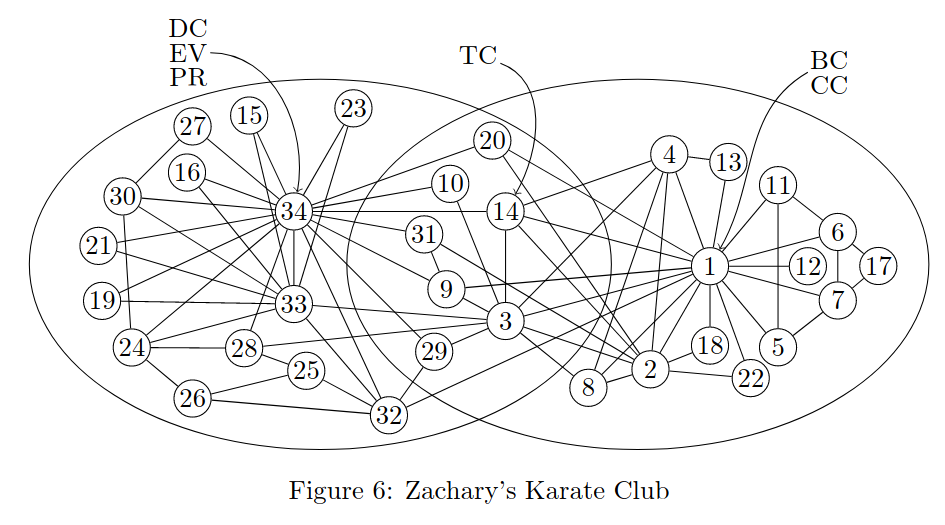

Here each nodes is plotted below with a label of its triangle centrality.  The layout is close enough to be discernable that this shows agreement of the highest ranked node (2.244)

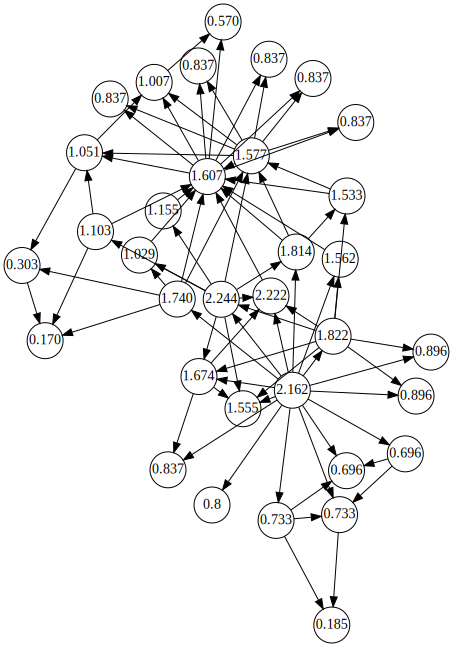

In [5]:
draw_graph(karate, label_vector=triangle_centrality2(karate), show_weight=False, label_width=5, graph_attr=dict(layout='neato'))

# Micro-benchmarks

In [6]:
%timeit triangle_centrality(karate)

167 µs ± 688 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit triangle_centrality2(karate)

100 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
y = list(Matrix.ssget('SNAP/com-Youtube'))[-1][1]
youtube = y + y.T

# Performance Results with Youtube

Here are the results from the paper on the SNAP/com-Youtube graph (28 core, 256GB):

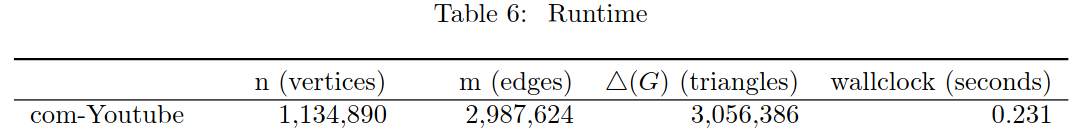

Here are the results for the same graph on a modest laptop (4 core, 32GB)

In [15]:
%timeit triangle_centrality2(youtube)

3.83 s ± 437 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
